In [ ]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Deploy and host a Stable Diffusion model on Vertex AI


<table align="left">

  <td>
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/stable_diffusion/dreambooth_stable_diffusion.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/stable_diffusion/dreambooth_stable_diffusion.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
 <td>
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/stable_diffusion/dreambooth_stable_diffusion.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      Open in Vertex AI Workbench
    </a>
  </td>
</table>

## Overview

This notebook demonstrates how to deploy and host a fine-tuned [Stable Diffusion 1.5](https://huggingface.co/runwayml/stable-diffusion-v1-5) model on Vertex AI. For hosting, you use the PyTorch 3 container built for Vertex AI with [TorchServe](https://pytorch.org/serve/index.html).

### Objective

In this tutorial, you learn how to host and deploy a Stable Diffusion 1.5 model on Vertex AI.

This tutorial uses the following Google Cloud ML services:

+ Vertex AI `Model` resource
+ Vertex AI `Endpoint` resource

The steps performed include:

+ Create a `torchserve` handler for responding to prediction requests.
+ Upload a Stable Diffusion 1.5 model on a prebuilt PyTorch container in Vertex AI.
+ Deploy a custom model to a Vertex AI Endpoint.
+ Send requests to the endpoint and parse the responses using Vertex AI Prediction service.

### Dataset

This notebook uses a collection of model artifacts fine-tuned to generate images of a small dog. These are the same images used in the original [DreamBooth paper](https://dreambooth.github.io/).

### Costs

This tutorial uses billable components of Google Cloud:

* Vertex AI models
* Vertex AI endpoints
* Vertex AI prediction
* Google Cloud Storage
* (Optionally) Vertex AI Workbench

Learn about [Vertex AI pricing](https://cloud.google.com/vertex-ai/pricing) and [Cloud Storage pricing](https://cloud.google.com/storage/pricing), and use the [Pricing Calculator](https://cloud.google.com/products/calculator/) to generate a cost estimate based on your projected usage.

## Hardware requirements

This notebook requires that you use a GPU with a sufficient amount of VRAM available. It was tested on a `Tesla P100-PCIE-16GB` with 16 MiB of VRAM. Run the following cell to ensure that you have the correct hardware configuration.

In [1]:
!nvidia-smi --query-gpu=name,memory.total,memory.free --format="csv,noheader"

NVIDIA A100-SXM4-40GB, 40960 MiB, 40354 MiB


### Create a user-managed notebook on Vertex AI

If you are using Vertex AI Workbench, you can create a notebook with the correct configuration by doing the following:

+ Go to [Vertex AI Workbench](https://console.cloud.google.com/vertex-ai/workbench/user-managed) in the Google Cloud Console.
+ Click **New Notebook** and then click **Python 3 (CUDA Toolkit 11.0)** > **With 1 NVIDIA T4**.
+ In the **New notebook** dialog box, click **Advanced Options**. The **Create a user-managed notebook** page opens up.
+ In the **Create a user-managed notebook** page, do the following:
  * In the **Notebook name** box, type a name for your notebook, for example "my-stablediffusion-nb".
  * In the **Machine type** drop-down, select **N1-standard** > **n1-standard-16**.
  * In the **GPU type** drop-down, select **NVIDIA Tesla P100**.
  * Check the box next to **Install NVIDIA GPU driver automatically for me**
  * Expand **Disk(s)** and do the following:
    - Under **Boot disk type**, select **SSD Persistent Disk**.
    - Under **Data disk type**, select **SSD Persistent Disk**.
  * Click **Create**.

<div style="background:#feefe3; padding:5px; color:#aa0000">
<strong>Caution:</strong> Using a Vertex AI Workbench notebook with the above configuration can increase your costs significantly. You can estimage your costs using the <a href="https://cloud.google.com/products/calculator"><u>costs calculator</u></a>.</div>

## Installation

Install the following packages required to execute this notebook.

**Note**: You might need to change the version of PyTorch (`torch`) installed by `pip`.

In [12]:
%%writefile requirements.txt
diffusers
ftfy
google-cloud-aiplatform
gradio
natsort
ninja
tensorboard==1.15.0
torch
torchaudio
torchvision
torchserve
torch-model-archiver
torch-workflow-archiver
transformers

Overwriting requirements.txt


In [13]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


### Colab only: Uncomment the following cell to restart the kernel.

In [ ]:
# Automatically restart kernel after installs so that your environment can access the new packages
# import IPython

# app = IPython.Application.instance()
# app.kernel.do_shutdown(True)

## Before you begin

### Set up your Google Cloud project

**The following steps are required, regardless of your notebook environment.**

1. [Select or create a Google Cloud project](https://console.cloud.google.com/cloud-resource-manager). When you first create an account, you get a $300 free credit towards your compute/storage costs.

2. [Make sure that billing is enabled for your project](https://cloud.google.com/billing/docs/how-to/modify-project).

3. [Enable the Vertex AI API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com).

4. If you are running this notebook locally, you need to install the [Cloud SDK](https://cloud.google.com/sdk).

#### Set your project ID

**If you don't know your project ID**, try the following:
* Run `gcloud config list`.
* Run `gcloud projects list`.
* See the support page: [Locate the project ID](https://support.google.com/googleapi/answer/7014113)

In [1]:
PROJECT_ID = "[your-project-id]"  # @param {type:"string"}

# Set the project id
! gcloud config set project {PROJECT_ID}

Updated property [core/project].


To take a quick anonymous survey, run:
  $ gcloud survey



#### Region

You can also change the `REGION` variable used by Vertex AI. Learn more about [Vertex AI regions](https://cloud.google.com/vertex-ai/docs/general/locations).

In [2]:
REGION = "us-central1"

### Authenticate your Google Cloud account

Depending on your Jupyter environment, you may have to manually authenticate. Follow the relevant instructions below.

**1. Vertex AI Workbench**
* Do nothing as you are already authenticated.

**2. Local JupyterLab instance, uncomment and run:**

In [ ]:
# ! gcloud auth login

**3. Colab, uncomment and run:**

In [ ]:
# from google.colab import auth
# auth.authenticate_user()

**4. Service account or other**
* See how to grant Cloud Storage permissions to your service account at https://cloud.google.com/storage/docs/gsutil/commands/iam#ch-examples.

### Import libraries

In [14]:
import base64
import gc
import math
import os
import torch

from diffusers import StableDiffusionPipeline
from glob import glob
from google.cloud import aiplatform
from IPython import display
from natsort import natsorted
from PIL import Image
from torch import autocast

## View model inferences

Before uploading the model to Vertex AI, you can review the expected output from the model. The model used in this notebook is available for your use and can be downloaded from Google Cloud Storage. This download may take a few minutes to complete.

In [32]:
!gsutil -m cp gs://cloud-samples-data/vertex-ai/model-deployment/models/stable-diffusion/model_artifacts.zip \
   .

Copying gs://cloud-samples-data/vertex-ai/model-deployment/models/stable-diffusion/model_artifacts.zip...
| [1/1 files][  3.6 GiB/  3.6 GiB] 100% Done  70.7 MiB/s ETA 00:00:00           
Operation completed over 1 objects/3.6 GiB.                                      


In [33]:
!unzip model_artifacts.zip

Archive:  model_artifacts.zip
   creating: model_artifacts/
   creating: model_artifacts/text_encoder/
  inflating: model_artifacts/text_encoder/pytorch_model.bin  
  inflating: model_artifacts/text_encoder/config.json  
   creating: model_artifacts/scheduler/
  inflating: model_artifacts/scheduler/scheduler_config.json  
   creating: model_artifacts/unet/
  inflating: model_artifacts/unet/diffusion_pytorch_model.bin  
  inflating: model_artifacts/unet/config.json  
  inflating: model_artifacts/model_index.json  
   creating: model_artifacts/feature_extractor/
  inflating: model_artifacts/feature_extractor/preprocessor_config.json  
   creating: model_artifacts/vae/
  inflating: model_artifacts/vae/diffusion_pytorch_model.bin  
  inflating: model_artifacts/vae/config.json  
  inflating: model_artifacts/args.json  
   creating: model_artifacts/tokenizer/
  inflating: model_artifacts/tokenizer/merges.txt  
  inflating: model_artifacts/tokenizer/special_tokens_map.json  
  inflating: mode

### Create new images

With everying in place, you can now generate new images from the Stable Diffusion model. First you must load your model into a `StableDiffusionPipeline`.

In [35]:
model_path = f"model_artifacts"

pipe = StableDiffusionPipeline.from_pretrained(
    model_path, torch_dtype=torch.float16
).to("cuda")

g_cuda = None

The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.
The config attributes {'class_embed_type': None, 'mid_block_type': 'UNetMidBlock2DCrossAttn', 'resnet_time_scale_shift': 'default', 'upcast_attention': False} were passed to UNet2DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.


In [36]:
g_cuda = torch.Generator(device="cuda")
seed = 52362
g_cuda.manual_seed(seed)

With the model loaded into a `StableDiffusionPipeline`, you can now generate results (inferences) from the model. Each set of inference requires an input (called a [prompt](https://learnprompting.org/)) that specifies what the model should create.

You can also vary other inputs into the model, as shown in the following cell.

In [41]:
prompt = "photo of examplePup dog in a Monet style"

num_samples = 4
num_batches = 1
num_columns = 2
guidance_scale = 10
num_inference_steps = 50
height = 512
width = 512

  0%|          | 0/51 [00:00<?, ?it/s]

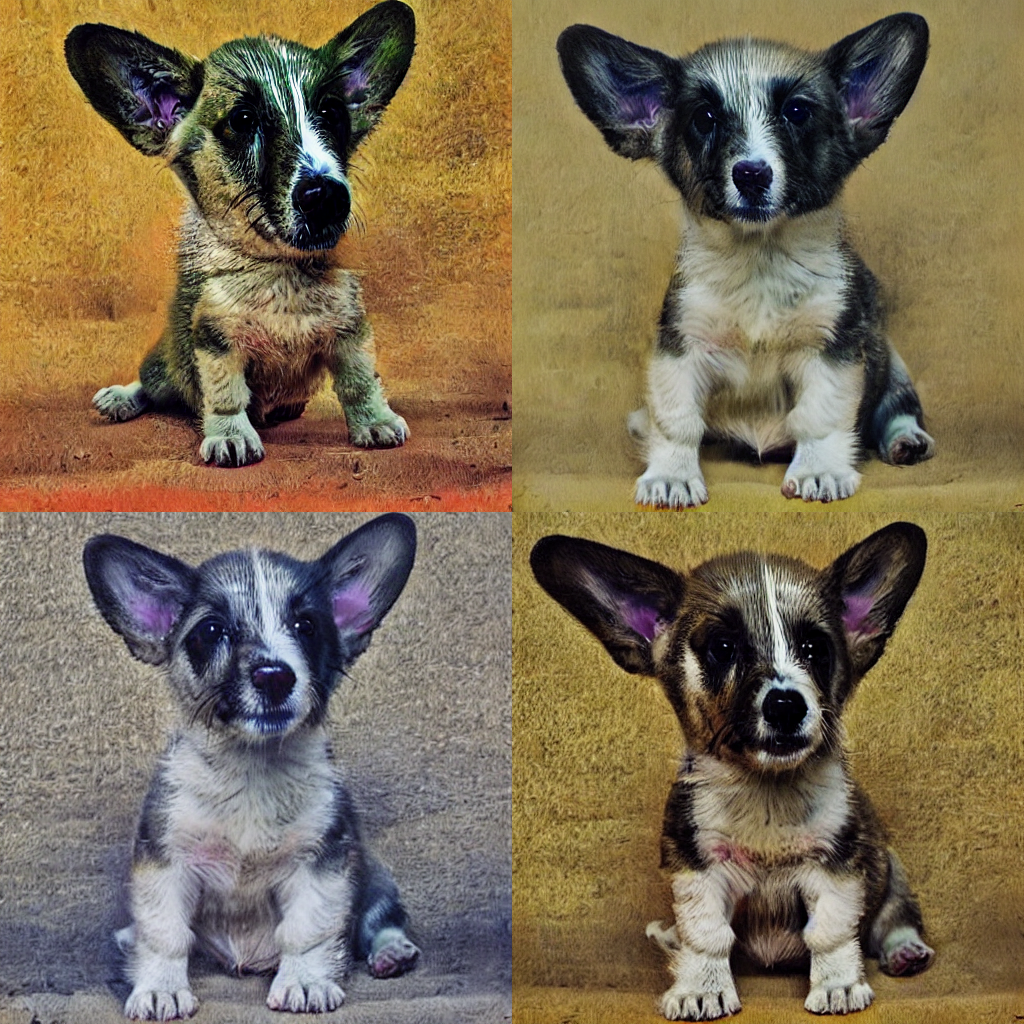

In [42]:
def image_grid(imgs, cols):
    total = len(imgs)
    rows = math.ceil(total / cols)

    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid


all_images = []
for _ in range(num_batches):
    with autocast("cuda"):
        images = pipe(
            [prompt] * num_samples,
            height=height,
            width=width,
            num_inference_steps=num_inference_steps,
            guidance_scale=guidance_scale,
        ).images
        all_images.extend(images)


grid = image_grid(all_images, num_columns)
grid

### Re-training the model

If you aren't satisfied with the inference outputs from the model, you can retrain it. Before you can do that, you might need to release the GPU memory.

In [ ]:
# Run this cell _only_ if you want to release the GPU memory.
pipe = None
gc.collect()
torch.cuda.empty_cache()

## Deploy the model to Vertex AI

You can host your Stable Diffusion 2.0 model on a Vertex AI endpoint where you can get inferences from it online. Uploading your model is a three step process: 

1. Create a custom TorchServe handler.
1. Upload the model artifacts onto Google Cloud Storage.
2. Create a Vertex AI model with the model artifacts and a prebuilt PyTorch container image.
3. Deploy the Vertex AI model onto an endpoint.

### Create the custom TorchServe handler

The model deployed to Vertex AI uses [TorchServe](https://pytorch.org/serve/) to handle requests and return responses from the model. You must create a custom TorchServe handler to include in with the model artifacts uploaded to Vertex AI.

The handler file should be included in the directory with the other model artifacts.

In [43]:
%%writefile model_artifacts/handler.py

"""Customized handler for Stable Diffusion 1.5."""
import base64
import logging
from io import BytesIO

import torch
from diffusers import EulerDiscreteScheduler
from diffusers import StableDiffusionPipeline
from ts.torch_handler.base_handler import BaseHandler

logger = logging.getLogger(__name__)
model_id = 'runwayml/stable-diffusion-v1-5'


class ModelHandler(BaseHandler):

  def __init__(self):
    self.initialized = False
    self.map_location = None
    self.device = None
    self.use_gpu = True
    self.store_avg = True
    self.pipe = None

  def initialize(self, context):
    """Initializes the pipe."""
    properties = context.system_properties
    gpu_id = properties.get('gpu_id')

    self.map_location, self.device, self.use_gpu = \
      ('cuda', torch.device('cuda:' + str(gpu_id)),
       True) if torch.cuda.is_available() else \
        ('cpu', torch.device('cpu'), False)

    # Use the Euler scheduler here instead
    scheduler = EulerDiscreteScheduler.from_pretrained(model_id,
                                                       subfolder='scheduler')
    pipe = StableDiffusionPipeline.from_pretrained(model_id,
                                                   scheduler=scheduler,
                                                   torch_dtype=torch.float16)
    pipe = pipe.to('cuda')
    # Uncomment the following line to reduce the GPU memory usage.
    # pipe.enable_attention_slicing()
    self.pipe = pipe

    self.initialized = True

  def preprocess(self, requests):
    """Noting to do here."""
    logger.info('requests: %s', requests)
    return requests

  def inference(self, preprocessed_data, *args, **kwargs):
    """Run the inference."""
    images = []
    for pd in preprocessed_data:
      prompt = pd['prompt']
      images.extend(self.pipe(prompt).images)
    return images

  def postprocess(self, output_batch):
    """Converts the images to base64 string."""
    postprocessed_data = []
    for op in output_batch:
      fp = BytesIO()
      op.save(fp, format='JPEG')
      postprocessed_data.append(base64.b64encode(fp.getvalue()).decode('utf-8'))
      fp.close()
    return postprocessed_data


Writing model_artifacts/handler.py


After creating the handler file, you must package the handler as a model archiver (MAR) file. The output file must be named 'model.mar'.

In [44]:
!torch-model-archiver \
  -f \
  --model-name model \
  --version 1.0 \
  --handler model_artifacts/handler.py \
  --export-path model_artifacts

### Upload the model artifacts to Google Cloud Storage

Create a new folder in your Google Cloud Storage bucket to hold the model artifacts

In [45]:
BUCKET_NAME = "your-bucket-name-unique"  # @param {type:"string"}
BUCKET_URI = f"gs://{BUCKET_NAME}/"
FULL_GCS_PATH = f"{BUCKET_URI}model_artifacts"

**Only if your bucket doesn't already exist**: Run the following cell to create your Cloud Storage bucket.

In [ ]:
! gsutil mb -l $REGION -p $PROJECT_ID $BUCKET_URI

Next, upload the model archive file and your trained Stable Diffusion 2.0 model to the folder on Cloud Storage.

In [46]:
!gsutil cp -r model_artifacts $BUCKET_URI

Copying file://model_artifacts/args.json [Content-Type=application/json]...
Copying file://model_artifacts/handler.py [Content-Type=text/x-python]...       
Copying file://model_artifacts/model.mar [Content-Type=application/octet-stream]...
Copying file://model_artifacts/model_index.json [Content-Type=application/json]...
- [4 files][  5.5 KiB/  5.5 KiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying file://model_artifacts/scheduler/scheduler_config.json [Content-Type=application/json]...
Copying file://model_artifacts/vae/diffusion_pytorch_model.bin [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uplo

### Create the Vertex AI model

Once you've uploaded the model artifacts into a Cloud Storage bucket, you can create a new Vertex AI model. This notebook uses the [Vertex AI SDK](https://cloud.google.com/vertex-ai/docs/start/use-vertex-ai-python-sdk) to create the model.

In [47]:
PYTORCH_PREDICTION_IMAGE_URI = (
    "us-docker.pkg.dev/vertex-ai/prediction/pytorch-gpu.1-12:latest"
)
APP_NAME = "my-stable-diffusion"
VERSION = 1
MODEL_DISPLAY_NAME = "stable_diffusion_1_4-unique"
MODEL_DESCRIPTION = "stable_diffusion_1_4 container"
ENDPOINT_DISPLAY_NAME = f"{APP_NAME}-endpoint"

In [48]:
aiplatform.init(project=PROJECT_ID, location=REGION, staging_bucket=BUCKET_NAME)

In [49]:
model = aiplatform.Model.upload(
    display_name=MODEL_DISPLAY_NAME,
    description=MODEL_DESCRIPTION,
    serving_container_image_uri=PYTORCH_PREDICTION_IMAGE_URI,
    artifact_uri=FULL_GCS_PATH,
)

model.wait()

print(model.display_name)
print(model.resource_name)

Creating Model
Create Model backing LRO: projects/147301782967/locations/us-central1/models/1432023735224762368/operations/2187512262162382848
Model created. Resource name: projects/147301782967/locations/us-central1/models/1432023735224762368@1
To use this Model in another session:
model = aiplatform.Model('projects/147301782967/locations/us-central1/models/1432023735224762368@1')
stable_diffusion_1_4-unique
projects/147301782967/locations/us-central1/models/1432023735224762368


### Deploy the model to an endpoint

To get online preductions from your Stable Diffusion 2.0 model, you must [deploy it to a Vertex AI endpoint](https://cloud.google.com/vertex-ai/docs/predictions/overview). You can again use the Vertex AI SDK to create the endpoint and deploy your model.

In [50]:
endpoint = aiplatform.Endpoint.create(display_name=ENDPOINT_DISPLAY_NAME)

Creating Endpoint
Create Endpoint backing LRO: projects/147301782967/locations/us-central1/endpoints/8407222147742695424/operations/1183772495212183552
Endpoint created. Resource name: projects/147301782967/locations/us-central1/endpoints/8407222147742695424
To use this Endpoint in another session:
endpoint = aiplatform.Endpoint('projects/147301782967/locations/us-central1/endpoints/8407222147742695424')


In [51]:
model.deploy(
    endpoint=endpoint,
    deployed_model_display_name=MODEL_DISPLAY_NAME,
    machine_type="n1-standard-8",
    accelerator_type="NVIDIA_TESLA_P100",
    accelerator_count=1,
    traffic_percentage=100,
    deploy_request_timeout=1200,
    sync=True,
)

Deploying model to Endpoint : projects/147301782967/locations/us-central1/endpoints/8407222147742695424
Deploy Endpoint model backing LRO: projects/147301782967/locations/us-central1/endpoints/8407222147742695424/operations/9008213897814999040
Endpoint model deployed. Resource name: projects/147301782967/locations/us-central1/endpoints/8407222147742695424


resource name: projects/147301782967/locations/us-central1/endpoints/8407222147742695424

The previous cell, which deploys your model to the nedpoint, can take a while to complete. If the previous cell times out before returning, your endpoint might still be successfully deployed ot an end point. Check the [Cloud Console](https://console.cloud.google.com/vertex-ai/endpoints) to verify the results.

You can also extend the time to wait for deployment by changing the `deploy_request_timeout` argument passed to `model.deploy()`.

## Get online predictions

Finally, with your Stable Diffusion 2.0 model deployed to a Vertex AI endpoint, you can now get online predictions from it. Using the Vertex AI SDK, you only need a few lines of code to get an inference.

In [52]:
instances = [{"prompt": "An examplePup dog with a baseball jersey."}]
response = endpoint.predict(instances=instances)

with open("img5.jpg", "wb") as g:
    g.write(base64.b64decode(response.predictions[0]))

AttributeError: 'function' object has no attribute 'Image'

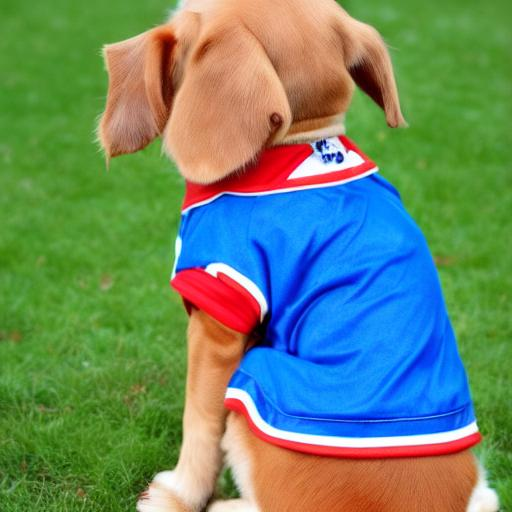

In [53]:


display.Image("img5.jpg")

## Cleaning up

To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial: